In [ ]:
#train, select best params on val, test on test
#for predict/plotting one year prediction, current train + predict is fine
#for hourly, i should incorporate most recent data point and predict one hour ahead

In [65]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel
import numpy as np
import pandas as pd
import requests
from hmmlearn import hmm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import time
from dateutil import parser
from matplotlib.collections import LineCollection
from itertools import product, zip_longest

In [31]:
def load_data():
    api_key = "beb360aad13e472f96c86f55e97b5bd9"
    # url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.HL".format(api_key)
    url = "http://api.eia.gov/series/?api_key={}&series_id=EBA.NY-ALL.D.H".format(api_key)
    response = requests.get(url)
    data = pd.DataFrame(response.json()['series'][0]['data'],columns = ['DateTime', 'Mwh'])
    data['DateTime'] = data['DateTime'].apply(lambda x: datetime.strptime(x, '%Y%m%dT%HZ'))
    data['Date'] = data['DateTime'].apply(lambda x: x.date())
    data['Time'] = data['DateTime'].apply(lambda x: x.time())
    data['Mwh'] = data['Mwh'].replace(0,np.nan).interpolate()
    splits = []
    splits.append(data[data['Date'] < datetime(year =2018, month=1, day = 1).date()])
    splits.append(data[(data['Date'] >= datetime(year =2018, month=1, day = 1).date()) & 
                       (data['Date'] < datetime(year =2019, month=1, day = 1).date())])
    splits.append(data[data['Date'] >= datetime(year =2019, month=1, day = 1).date()])
    for idx in range(len(splits)):
        splits[idx] = splits[idx].iloc[::-1].reset_index(drop=True)
        splits[idx] = splits[idx].set_index(['DateTime'])[['Date','Time','Mwh']]
    return splits[0], splits[1], splits[2]
train, val, test = load_data()

In [32]:
#create train df sorted by year, month, day and summed by day
times_train = pd.DatetimeIndex(train.index)
train_ymdh = train.groupby([times_train.month,times_train.day,times_train.hour]).mean()

#create val df sorted by year, month, day and summed by day
times_val = pd.DatetimeIndex(val.index)
val_ymdh = val.groupby([times_val.month,times_val.day,times_val.hour]).mean()

#create test df sorted by year, month, day and summed by day
times_test = pd.DatetimeIndex(test.index)
test_ymdh = test.groupby([times_test.month,times_test.day,times_test.hour]).mean()

X_train = list(train_ymdh.index)
y_train = train_ymdh['Mwh'].values

X_val = list(val_ymdh.index)
y_val = val_ymdh['Mwh'].values

TypeError: can only concatenate str (not "numpy.float64") to str

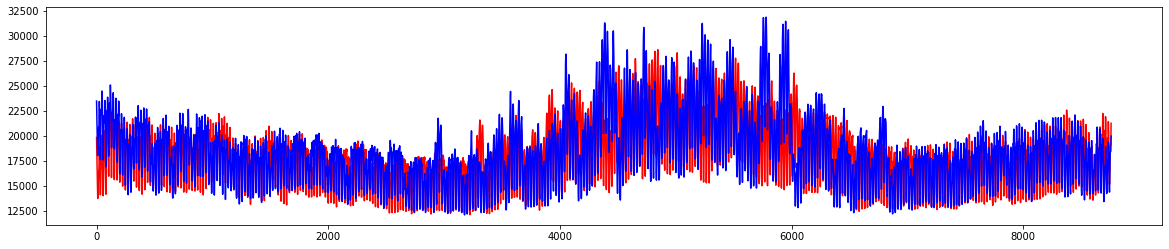

In [33]:
#changing train, val, test to group determined periods

X_train = list(train_ymdh.index)
y_train = train_ymdh['Mwh'].values

X_val = list(val_ymdh.index)
y_val = val_ymdh['Mwh'].values

pred_dt_hr = list(val_ymdh.index)
kernel_list = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared()]
preds = {}
train_score = {}
val_score = {}

fig, ax = plt.subplots(figsize=(20, 4))

'''for kernel in kernel_list:
    gpr = GaussianProcessRegressor(kernel = kernel, random_state=0).fit(X_train, y_train)
    preds[str(kernel)] = gpr.predict(X_val)
    train_score[str(kernel)] = gpr.score(X_train, y_train)
    val_score[str(kernel)] = gpr.score(X_val, y_val)
    ax.plot(range(len(pred_dt_hr)),preds[str(kernel)],c='r')
    ax.plot(range(len(pred_dt_hr)),y_val,c='b')
    ax.title(str(kernel)+'tr_score: '+train_score[str(kernel)]+';val_score: '+val_score[str(kernel)])'''
 
kernel = RationalQuadratic()
gpr = GaussianProcessRegressor(kernel = kernel, random_state=0).fit(X_train, y_train)
preds[str(kernel)] = gpr.predict(X_val)
train_score[str(kernel)] = gpr.score(X_train, y_train)
val_score[str(kernel)] = gpr.score(X_val, y_val)
ax.plot(range(len(pred_dt_hr)),preds[str(kernel)],c='r')
ax.plot(range(len(pred_dt_hr)),y_val,c='b')
ax.title(str(kernel)+'tr_score: '+str(train_score[str(kernel)])+';val_score: '+str(val_score[str(kernel)]))

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 1.0, 'kernel__alpha': 1.0, 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel__alpha_bounds': (1e-05, 100000.0), 'kernel': RationalQuadratic(alpha=1, length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0}
tr_score:  1.0
val_score:  0.5862231748080411


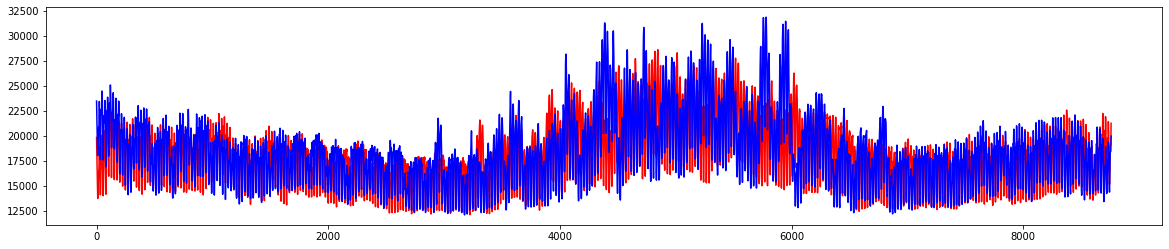

In [54]:
gprRQ = GaussianProcessRegressor(kernel = RationalQuadratic(), random_state=0).fit(X_train, y_train)
print(gprRQ.get_params())
preds['RationalQuadratic'] = gprRQ.predict(X_val)
train_score['RationalQuadratic'] = gprRQ.score(X_train, y_train)
val_score['RationalQuadratic'] = gprRQ.score(X_val, y_val)

kernel='RationalQuadratic'

print('tr_score: ',str(train_score['RationalQuadratic']))
print('val_score: ',str(val_score['RationalQuadratic']))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds['RationalQuadratic'])),preds['RationalQuadratic'],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()


tr_score:  1.0
val_score:  0.5862231748080411


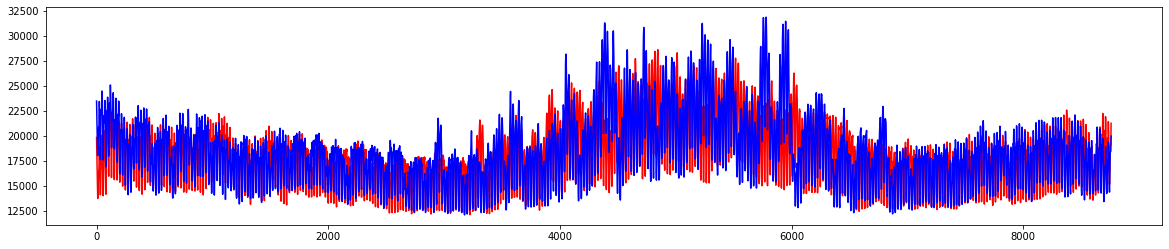

In [49]:
kernel='RationalQuadratic'

print('tr_score: ',str(train_score['RationalQuadratic']))
print('val_score: ',str(val_score['RationalQuadratic']))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds['RationalQuadratic'])),preds['RationalQuadratic'],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()


tr_score:  1.0
val_score:  0.5862231748711519


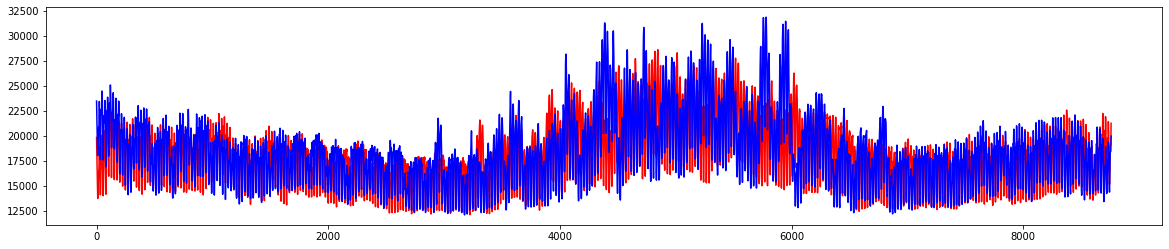

In [50]:
gpr = GaussianProcessRegressor(kernel = RBF(), random_state=0).fit(X_train, y_train)
kernel = 'RBF'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

In [53]:
print(gpr.get_params())

{'alpha': 1e-10, 'copy_X_train': True, 'kernel__length_scale': 1.0, 'kernel__length_scale_bounds': (1e-05, 100000.0), 'kernel': RBF(length_scale=1), 'n_restarts_optimizer': 0, 'normalize_y': False, 'optimizer': 'fmin_l_bfgs_b', 'random_state': 0}


In [55]:
#normalize y
gpr = GaussianProcessRegressor(kernel = RBF(normalize_y=True), random_state=0).fit(X_train, y_train)
print(gpr.get_params())
kernel = 'RBF_norm_y'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

TypeError: __init__() got an unexpected keyword argument 'normalize_y'

In [ ]:
#random restarts and norm y
gpr = GaussianProcessRegressor(kernel = RBF(n_restarts_optimizer: 5, normalize_y=True), random_state=0).fit(X_train, y_train)
print(gpr.get_params())
kernel = 'RBF_rand_norm_y'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

In [ ]:
#random restarts 
gpr = GaussianProcessRegressor(kernel = RBF(n_restarts_optimizer: 5), random_state=0).fit(X_train, y_train)
print(gpr.get_params())
kernel = 'RBF_rand'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

In [ ]:
gpr = GaussianProcessRegressor(random_state=0).fit(X_train, y_train)
kernel = 'ExpSineSquared'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

tr_score:  -0.03975971776816345
val_score:  -0.04103664021711828


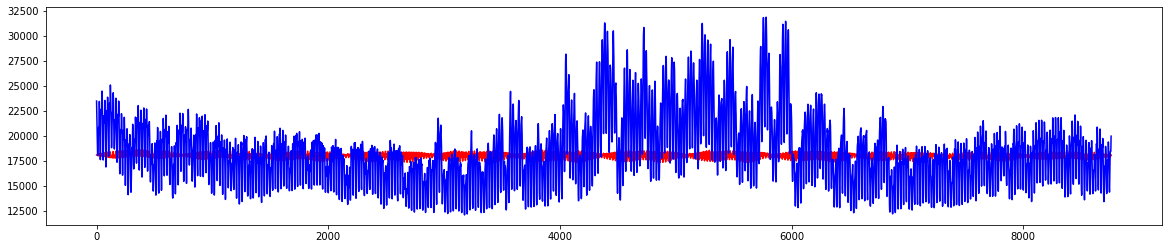

In [74]:
#a=1000 is too high. result is straight line
#a=100 is too low
a = 20
kern=1*ExpSineSquared(length_scale=10,periodicity=12, \
  length_scale_bounds=(1,10000),periodicity_bounds=(8,16)) \
  + WhiteKernel(noise_level=1,noise_level_bounds=(0.01,0.5))

gpr = GaussianProcessRegressor(alpha = a, kernel = kern, random_state=0).fit(X_train, y_train)
kernel = 'ExpSineSquared'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

tr_score:  -4.4569002973560146e-05
val_score:  -0.009805918076306597


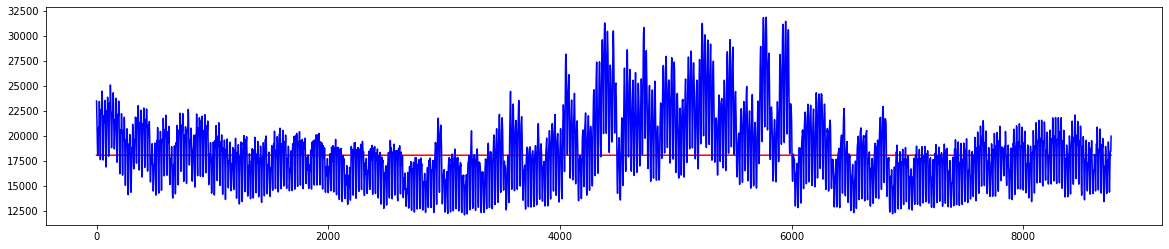

In [76]:
#a=1000 is too high. result is straight line
#a=100 is too low
a = 20
kern=1*ExpSineSquared(length_scale = 1, periodicity=12,periodicity_bounds=(8,16)) \
  + WhiteKernel(noise_level=1,noise_level_bounds=(0.01,0.5))

gpr = GaussianProcessRegressor(alpha = a, kernel = kern, random_state=0).fit(X_train, y_train)
kernel = 'ExpSineSquared'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

In [72]:
#RBF * Exponential = locally periodic
#a=1000 is too high. result is straight line
#a=100 is too low
a = 1
kern=1*RBF(length_scale=10,periodicity=12, \
  length_scale_bounds=(1,10000),periodicity_bounds=(8,16)) \
  *ExpSineSquared(length_scale=10,periodicity=12, \
  length_scale_bounds=(1,10000),periodicity_bounds=(8,16)) \
  + WhiteKernel(noise_level=1,noise_level_bounds=(0.01,0.5))

gpr = GaussianProcessRegressor(alpha = a, kernel = kern, random_state=0).fit(X_train, y_train)
kernel = 'ExpSineSquared'
preds[kernel] = gpr.predict(X_val)
train_score[kernel] = gpr.score(X_train, y_train)
val_score[kernel] = gpr.score(X_val, y_val)

print('tr_score: ',str(train_score[kernel]))
print('val_score: ',str(val_score[kernel]))

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(range(len(preds[kernel])),preds[kernel],c='r')
ax.plot(range(len(y_val)),y_val,c='b')

plt.show()

TypeError: __init__() got an unexpected keyword argument 'periodicity'

In [ ]:
#choose best model from validation. prob RBF.
#test on next 24 hours of test data using sliding window
X_train.append(X_val)
y_train.append(y_val)

start = 0
end = 23
X_test = list(test_ymdh.index)[start:end]
y_test = test_ymdh['Mwh'].values[start:end]

kernel = 'RBF_test'
pred_test = {}
rmse_test = {}
test_score = {}

for d in range(1,len(test_ymdh.day)):
    gpr = GaussianProcessRegressor(kernel = RBF(), random_state=0).fit(X_train, y_train)
    #predict next 24hrs
    pred_test[d] = gpr.predict(X_test)
    rmse_test[d] = np.sqrt(np.mean((pred_test[d]-X_test)**2))
    test_score[d] = gpr.score(X_test, y_test)
    
    #roll forward 24hours
    X_train.append(X_test)
    y_train.append(y_test)
    
    start = end+1
    end = start+24
    X_test = list(test_ymdh.index)[start:end]
    y_test = test_ymdh['Mwh'].values[start:end]

print('days tested: ',len(rmse_test), np.sum(rmse_test.values), np.mean(rmse_test.values))

In [ ]:
#convert train index of datetime to tuple of day,month,year
train.index
train.index.strftime('%B %d, %Y, %r')

In [ ]:
train.index.strftime('%B %d, %Y, %r')

ValueError: x and y must have same first dimension, but have shapes (8067,) and (8760,)

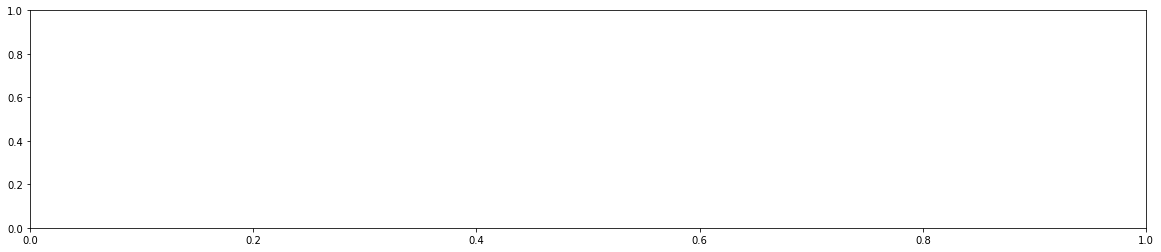

In [36]:
#train and validate for hourly data
#changing train, val, test to group determined periods

X_train = list(train_ymdh.index)
y_train = train_ymdh['Mwh'].values

X_val = list(val_ymdh.index)
y_val = val_ymdh['Mwh'].values

pred_dt_hr = list(test_ymdh.index)
kernel_list = [RBF(), Matern(), ExpSineSquared()]
preds = {}
train_score = {}
val_score = {}

fig, ax = plt.subplots(figsize=(20, 4))

for kernel in kernel_list:
    gpr = GaussianProcessRegressor(kernel = kernel, random_state=0).fit(X_train, y_train)
    preds[str(kernel)] = gpr.predict(X_val)
    train_score[str(kernel)] = gpr.score(X_train, y_train)
    val_score[str(kernel)] = gpr.score(X_val, y_val)
    ax.plot(range(len(pred_dt_hr)),preds[str(kernel)],c='r')
    ax.plot(range(len(pred_dt_hr)),y_val,c='b')
    ax.title(str(kernel)+'tr_score: '+str(train_score[str(kernel)])+';val_score: '+str(val_score[str(kernel)]))
    

In [56]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


ModuleNotFoundError: No module named 'torch'

In [ ]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [ ]:
train_